In [1]:
from unityagents import UnityEnvironment

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

import numpy as np
import random
import copy
from collections import namedtuple, deque

import os

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
def hard_update(target, source):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(param.data)
        
def soft_update(target, source, tau):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)

In [4]:
def seeding(seed=10):
    np.random.seed(seed)
    torch.manual_seed(seed)

In [5]:
class OUNoise:
    def __init__(self, action_dimension, scale=0.1, mu=0, theta=0.15, sigma=0.2):
        self.action_dimension = action_dimension
        self.scale = scale
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.state = np.ones(self.action_dimension) * self.mu
        self.reset()

    def reset(self):
        self.state = np.ones(self.action_dimension) * self.mu

    def noise(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(len(x))
        self.state = x + dx
        return torch.tensor(self.state * self.scale).float()

In [6]:
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size, seed):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "full_state", "action", "reward", "next_state", "full_next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, full_state, action, reward, next_state, full_next_state, done):
        e = self.experience(state, full_state, action, reward, next_state, full_next_state, done)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        full_states = torch.from_numpy(np.vstack([e.full_state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(
            device)
        full_next_states = torch.from_numpy(np.vstack([e.full_next_state for e in experiences if e is not None])).float().to(
            device)
        dones = torch.from_numpy(
            np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(
            device)

        return (states, full_states, actions, rewards, next_states, full_next_states, dones)

    def __len__(self):
        return len(self.memory)

In [7]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    def __init__(self, state_size, action_size, seed=1, fc_units=256, fc_units1=128, fc_units2=128):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_size, fc_units)
        self.fc2 = nn.Linear(fc_units, fc_units1)
        self.fc3 = nn.Linear(fc_units1, fc_units2)
        self.fc4 = nn.Linear(fc_units2, action_size)

        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(*hidden_init(self.fc3))
        self.fc4.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))

        return torch.tanh(self.fc4(x))


class Critic(nn.Module):
    def __init__(self, state_size, action_size, num_agent, seed=1, fc_units=256, fc_units1=128, fc_units2=128):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear((state_size + action_size) * num_agent, fc_units)
        self.fc2 = nn.Linear(fc_units, fc_units1)
        self.fc3 = nn.Linear(fc_units1, fc_units2)
        self.fc4 = nn.Linear(fc_units2, 1)

        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(*hidden_init(self.fc3))
        self.fc4.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        x = torch.cat((state, action), dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))

        return self.fc4(x)

In [8]:
class DDPGAgent:
    def __init__(self, state_size, action_size, num_agents, seed=0, lr_actor=1.0e-4, lr_critic=1.0e-3):
        super(DDPGAgent, self).__init__()
        
        self.actor = Actor(state_size, action_size).to(device)
        self.critic = Critic(state_size, action_size, num_agents, seed=seed).to(device)

        self.target_actor = Actor(state_size, action_size).to(device)
        self.target_critic = Critic(state_size, action_size, num_agents, seed=seed).to(device)

        self.noise = OUNoise(action_size, scale=1.0)

        hard_update(self.target_actor, self.actor)
        hard_update(self.target_critic, self.critic)

        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr_actor)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr_critic)

    def act(self, obs, noise=0.0):
        obs = obs.to(device)
        action = self.actor(obs).cpu().data + noise * self.noise.noise()
        return np.clip(action, -1, 1)

    def target_act(self, obs, noise=0.0):
        obs = obs.to(device)
        action = self.target_actor(obs).cpu().data + noise * self.noise.noise()
        return np.clip(action, -1, 1)

In [9]:
class MADDPG:
    def __init__(self, state_size, action_size, num_agents, seed, discount_factor=0.95, tau=0.02):
        super(MADDPG, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.num_agents = num_agents

        self.maddpg_agent = [DDPGAgent(state_size, action_size, num_agents, seed),
                             DDPGAgent(state_size, action_size, num_agents, seed)]

        self.discount_factor = discount_factor
        self.tau = tau
        self.iter = 0

    def get_actors(self):
        actors = [ddpg_agent.actor for ddpg_agent in self.maddpg_agent]
        return actors

    def get_target_actors(self):
        target_actors = [ddpg_agent.target_actor for ddpg_agent in self.maddpg_agent]
        return target_actors

    def act(self, obs_all_agents, noise=0.0):
        return [self.maddpg_agent[i].act(obs_all_agents[i, :].view(1, -1), noise).squeeze() for i in range(self.num_agents)]

    def target_act(self, obs_all_agents, noise=0.0):
        return [self.maddpg_agent[i].target_act(obs_all_agents[:, i, :],  noise).squeeze() for i in range(self.num_agents)] 

    def update(self, samples, agent_number):
        state, full_state, action, reward, next_state, full_next_state, done = samples

        batch_size = full_state.shape[0]

        agent = self.maddpg_agent[agent_number]
        agent.critic_optimizer.zero_grad()

        target_actions = self.target_act(next_state.view(batch_size, self.num_agents, -1))

        target_actions = torch.cat(target_actions, dim=1)

        with torch.no_grad():
            q_next = agent.target_critic(full_next_state, target_actions.to(device))

        y = reward[:, agent_number].view(-1, 1) + self.discount_factor * q_next * (1 - done[:, agent_number].view(-1, 1))

        q = agent.critic(full_state, action.view(batch_size, -1))

        critic_loss = F.mse_loss(q, y.detach())

        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(agent.critic.parameters(), 1)
        agent.critic_optimizer.step()

        agent.actor_optimizer.zero_grad()

        q_input = [
            self.maddpg_agent[i].actor(state.view([batch_size, self.num_agents, -1])[:, i, :]) if i == agent_number else
            self.maddpg_agent[i].actor(state.view([batch_size, self.num_agents, -1])[:, i, :]).detach() for i in range(self.num_agents)]

        q_input = torch.cat(q_input, dim=1)

        actor_loss = -agent.critic(full_state, q_input).mean()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(agent.actor.parameters(), 1)
        agent.actor_optimizer.step()

        self.update_targets()

    def update_targets(self):
        """soft update targets"""
        self.iter += 1
        for ddpg_agent in self.maddpg_agent:
            soft_update(ddpg_agent.target_actor, ddpg_agent.actor, self.tau)
            soft_update(ddpg_agent.target_critic, ddpg_agent.critic, self.tau)


In [10]:
seeding()

env = UnityEnvironment(file_name="./Tennis_Windows_x86_64/Tennis.exe", no_graphics=True)
env_name = "Tennis MADDPG"

brain_name = env.brain_names[0]
brain = env.brains[brain_name]

env_info = env.reset(train_mode=True)[brain_name]

num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like: ', states[0]) 

num_eps = 10000
eps_length = 10000
batchsize = 128
noise = 1
noise_reduction = 0.999

model_dir = os.getcwd() + "/model_dir"

os.makedirs(model_dir, exist_ok=True)

buffer = ReplayBuffer(int(500000), batchsize, 0)

maddpg = MADDPG(state_size, action_size, num_agents, seed=10, discount_factor=0.95, tau=0.02)

eps_per_update = 2

print_every = 500
scores_deque = deque(maxlen=100)

scores = []
avg_100 = []

threshold = 0.5

for eps in range(num_eps):
    env_info = env.reset(train_mode=True)[brain_name] 
    state = env_info.vector_observations  
    agent0_reward = 0
    agent1_reward = 0

    for agent in maddpg.maddpg_agent:
        agent.noise.reset()

    for eps_t in range(eps_length):
        actions = maddpg.act(torch.tensor(state, dtype=torch.float), noise=noise)
        noise *= noise_reduction

        actions_array = torch.stack(actions).detach().numpy()

        env_info = env.step(actions_array)[brain_name]
        next_state = env_info.vector_observations

        reward = env_info.rewards
        done = env_info.local_done

        agent0_reward += reward[0]
        agent1_reward += reward[1]

        full_state = np.concatenate((state[0], state[1]))
        full_next_state = np.concatenate((next_state[0], next_state[1]))

        buffer.add(state, full_state, actions_array, reward, next_state, full_next_state, done)

        state = next_state

        if len(buffer) > batchsize and eps % eps_per_update == 0:
            for i in range(num_agents):
                samples = buffer.sample()
                maddpg.update(samples, i)
            maddpg.update_targets()  

        if np.any(done):
            break

    eps_reward = max(agent0_reward, agent1_reward)
    scores.append(eps_reward)
    scores_deque.append(eps_reward)
    avg_100.append(np.mean(scores_deque))
    print('\rEpisode {}\tAverage Score: {:.4f}\tScore: {:.4f}'.format(eps, avg_100[-1],
                                                                                    eps_reward),
          end="")

    if eps % print_every == 0:
        print('\rEpisode {}\tAverage Score: {:.4f}'.format(eps, avg_100[-1]))

    if avg_100[-1] >= threshold:
        save_dict_list = []

        for i in range(num_agents):
            save_dict = {'actor_params': maddpg.maddpg_agent[i].actor.state_dict(),
                         'actor_optim_params': maddpg.maddpg_agent[i].actor_optimizer.state_dict(),
                         'critic_params': maddpg.maddpg_agent[i].critic.state_dict(),
                         'critic_optim_params': maddpg.maddpg_agent[i].critic_optimizer.state_dict()}
            save_dict_list.append(save_dict)

            torch.save(save_dict_list,
                       os.path.join(model_dir, 'episode-{}.pt'.format(eps)))
        break

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Number of agents: 2
Number of actions: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like:  [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]
Episode 0	Average Score: 0.0000	Score: 0.0000
Episode 500	Average Score: 0.0515	Score: 0.1000
Episode 1000	Average Score: 0.1057	Score: 0.1000
Episode 1500	Average Score: 0.1005	Score: 0.1000
Episode 2000	Average Score: 0.1400	Score: 0.2000
Episode 2500	Average Score: 0.1851	Score: 0.8000
Episode 2995	Average Score: 0.5049	Score: 0.9000

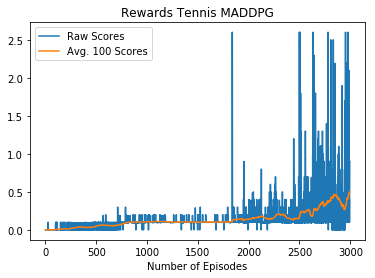

In [18]:
x = np.arange(0, len(scores))
y = np.asarray(avg_100)
plt.plot(x, scores)
plt.plot(x, y)
plt.xlabel("Number of Episodes")
plt.legend(['Raw Scores', 'Avg. 100 Scores'], loc='upper left')
plt.title("Rewards %s" %env_name)
plt.savefig("progress.png")

In [24]:
env.close()

In [25]:
env = UnityEnvironment(file_name="./Tennis_Windows_x86_64/Tennis.exe", no_graphics=True)

brain_name = env.brain_names[0]
brain = env.brains[brain_name]

env_info = env.reset(train_mode=False)[brain_name]

num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like: ', states[0]) 

num_eps = 100
eps_length = 10000

scores_deque = deque(maxlen=100)

scores = []
avg_100 = []

for eps in range(num_eps):
    env_info = env.reset(train_mode=True)[brain_name] 
    state = env_info.vector_observations  
    agent0_reward = 0
    agent1_reward = 0

    for eps_t in range(eps_length):
        actions = maddpg.act(torch.tensor(state, dtype=torch.float), noise=0)

        actions_array = torch.stack(actions).detach().numpy()

        env_info = env.step(actions_array)[brain_name]
        next_state = env_info.vector_observations

        reward = env_info.rewards
        done = env_info.local_done

        agent0_reward += reward[0]
        agent1_reward += reward[1]

        state = next_state
        if np.any(done):
            break

    eps_reward = max(agent0_reward, agent1_reward)
    scores.append(eps_reward)
    scores_deque.append(eps_reward)
    avg_100.append(np.mean(scores_deque))
    print('Episode {}\tAverage Score: {:.4f}\tScore: {:.4f}\n'.format(eps, avg_100[-1], eps_reward),end="")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Number of agents: 2
Number of actions: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like:  [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]
Episode 0	Average Score: 0.1900	Score: 0.1900
Episode 1	Average Score: 0.1450	Score: 0.1000
Episode 2	Average Score: 0.1633	Score: 0.2000
Episode 3	Average Score: 0.1725	Score: 0.2000
Episode 4	Average Score: 0.4780	Score: 1.7000
Episode 5	Average Score: 0.6983	Score: 1.8000
Episode 6	Average Score: 0.9700	Score: 2.6000
Episode 7	Average Score: 0.9363	Score: 0.7000
Episode 8	Average Score: 0.8544	Score: 0.2000
Episode 9	Average Score: 0.7990	Score: 0.3000
Episode 10	Average Score: 0.7627	Score: 0.4000
Episode 11	Average Score: 0.8575	Score: 1.9000
Episode 12	Average Score: 0.8454	S

In [26]:
env.close()